In [1]:
import os
import shutil
import sqlite3
from datetime import datetime, timedelta

In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pandas.core.frame import DataFrame
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler

In [3]:
DATE_FORMAT = "%Y-%m-%d %H:%M:%S"

CONFIG

In [4]:
plt.style.use("fivethirtyeight")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [5]:
BEST_KMEANS_CLUSTERS_NUMBER = 4

In [6]:
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 50,
    "max_iter": 500,
    "random_state": 42
}

In [7]:
def load_data(nb_elements=9999999):
    """Load the data from the db, extract the RFM and average review attributes and returns them."""
    con = sqlite3.connect("resources/olist.db")
    con.row_factory = sqlite3.Row
    cur = con.cursor()
    
    res = cur.execute("""SELECT customer_id, customer_unique_id FROM customers
    where customer_id in (select customer_id from orders)""")
    customers = res.fetchall()
    
    res = cur.execute(
        """SELECT o.order_id, o.customer_id, o.order_purchase_timestamp, oi.price
    FROM orders o
    inner join order_items oi on o.order_id = oi.order_id""")
    orders = res.fetchall()
    
    cur.close()
    con.close()
    
    sorted_orders = {}
    for order in [dict(order) for order in orders]:
        sorted_orders.setdefault(order['customer_id'], []).append(order)
        
    sorted_customers = {}
    for customer in [dict(customer) for customer in customers]:
        sorted_customers.setdefault(
            customer['customer_unique_id'], []).append(
            customer['customer_id'])
        
    clients = []
    overall_earliest_purchase_date = None
    overall_latest_purchase_date = None
    for customer_unique_id in sorted_customers.keys():
        customer_ids = sorted_customers[customer_unique_id]
        
        customer_orders = []
        for customer_id in customer_ids:
            customer_orders += sorted_orders[customer_id] if customer_id in sorted_orders else []
            
        if len(customer_orders) == 0:
            continue
            
        total_amount = sum([order['price'] for order in customer_orders])
        nb_products = len(customer_orders)
        
        order_timestamps = [
            datetime.strptime(
                order['order_purchase_timestamp'],
                DATE_FORMAT) for order in customer_orders]
        latest_purchase_date: datetime = max(order_timestamps)
        earliest_purchase_date: datetime = min(order_timestamps)
        days_since_last_purchase = (datetime.now() - latest_purchase_date).days
        
        if overall_earliest_purchase_date is None or overall_earliest_purchase_date > earliest_purchase_date:
            overall_earliest_purchase_date = earliest_purchase_date
        if overall_latest_purchase_date is None or overall_latest_purchase_date < latest_purchase_date:
            overall_latest_purchase_date = latest_purchase_date

        # Excludes 71 clients for a better visibility of the clusters
        if nb_products < 8:
            clients.append({
                'recency': days_since_last_purchase,
                'frequency': nb_products,
                'monetary_value': total_amount
            })
    return clients[:nb_elements], overall_earliest_purchase_date, overall_latest_purchase_date

In [8]:
def get_kmeans_model_fit_on_clients(clients):
    """Fit a Kmeans model with the best number of clusters on the given clients and returns it."""
    scaled_clients = DataFrame(
        StandardScaler().fit_transform(
            DataFrame(clients)))
    
    model = KMeans(n_clusters=BEST_KMEANS_CLUSTERS_NUMBER, **kmeans_kwargs)
    model.fit(scaled_clients)
    
    return model

In [9]:
def create_ari_scores_plot(ari_results, max_weeks_number, is_first=True):
    """Generate and display a plot showing the ARI scores by week number."""
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 12)
    
    plot = sns.lineplot(
        DataFrame(ari_results),
        x="weeks_number",
        y="ari_score",
        ax=ax)
    
    plot.set_title("ARI score per week")
    plot.set_xlabel("Weeks number")
    plot.set_ylabel("ARI score")
    ax.hlines(
        y=0.7,
        xmin=1,
        xmax=max_weeks_number,
        color='black',
        linestyles='dashdot')
    
    # fig.savefig(
        # f"simulation_plots/ari_scores_{'first' if is_first else 'second'}_method.png")
    plt.show()
    plt.close()

In [10]:
def create_ari_scores_plot_using_first_method(
        clients,
        overall_earliest_purchase_date,
        overall_week_numbers):
    """Calculate and display the ARI scores of the simulation using two periods with a similar number of weeks."""
    
    print("Starting simulation using the first method.\n")
    ari_results = []
    max_weeks_number = int(overall_week_numbers / 2 + 1)
    
    for weeks_number in range(1, max_weeks_number):
        print(
            f"Considering periods of {weeks_number} week{
                's' if weeks_number > 1 else ''}.")
        
        days_since_first_period_start = (
            datetime.now() - overall_earliest_purchase_date).days
        first_period_end_date = overall_earliest_purchase_date + \
            timedelta(weeks=weeks_number)
        days_since_first_period_end = (
            datetime.now() - first_period_end_date).days
        first_timeperiod_clients = [client for client in clients if days_since_first_period_end < client['recency']
                                    <= days_since_first_period_start]
        
        days_since_second_period_start = days_since_first_period_end
        second_period_end_date = overall_earliest_purchase_date + \
            timedelta(weeks=2 * weeks_number)
        days_since_second_period_end = (
            datetime.now() - second_period_end_date).days
        second_timeperiod_clients = [client for client in clients if days_since_second_period_end < client['recency']
                                     <= days_since_second_period_start]
        
        all_periods_clients = first_timeperiod_clients + second_timeperiod_clients
        
        if (len(first_timeperiod_clients) < BEST_KMEANS_CLUSTERS_NUMBER or
                len(second_timeperiod_clients) < BEST_KMEANS_CLUSTERS_NUMBER):
            print(
                "Not enough clients in one of the time periods, skipping this iteration.\n")
            continue
        else:
            print(
                f"Number of clients in the first time period: {
                    len(first_timeperiod_clients)}, " f"number of clients in the second time period: {
                    len(second_timeperiod_clients)}.")
            
        model_a = get_kmeans_model_fit_on_clients(first_timeperiod_clients)
        model_b = get_kmeans_model_fit_on_clients(all_periods_clients)
        
        scaled_second_period_clients = DataFrame(
            StandardScaler().fit_transform(
                DataFrame(second_timeperiod_clients)))
        
        model_a_labels = model_a.predict(scaled_second_period_clients)
        model_b_labels = model_b.predict(scaled_second_period_clients)
        
        ari_score = round(
            adjusted_rand_score(
                model_a_labels,
                model_b_labels),
            4)
        ari_results.append(
            {'weeks_number': weeks_number, 'ari_score': ari_score})
        print(f"ARI score:{ari_score} for weeks number:{weeks_number}.\n")
        
    create_ari_scores_plot(ari_results, max_weeks_number)

In [11]:
def create_ari_scores_plot_using_second_method(
        all_clients,
        overall_earliest_purchase_date,
        overall_latest_purchase_date,
        overall_week_numbers):
    """Calculate and display the ARI scores of the simulation using a first period of the given number of week and
    a second period of the remaining weeks of the data.
    """
    
    print("Starting simulation using the second method.\n")
    ari_results = []
    for weeks_number in range(1, overall_week_numbers):
        print(
            f"Considering periods of {weeks_number} week{
                's' if weeks_number > 1 else ''}.")
        
        days_since_first_period_start = (
            datetime.now() - overall_earliest_purchase_date).days
        first_period_end_date = overall_earliest_purchase_date + \
            timedelta(weeks=weeks_number)
        days_since_first_period_end = (
            datetime.now() - first_period_end_date).days
        first_timeperiod_clients = [client for client in clients if days_since_first_period_end < client['recency']
                                    <= days_since_first_period_start]
        
        days_since_second_period_start = days_since_first_period_end
        days_since_second_period_end = (
            datetime.now() - overall_latest_purchase_date).days
        second_timeperiod_clients = [client for client in all_clients if days_since_second_period_end < client['recency']
                                     <= days_since_second_period_start]
        
        all_periods_clients = first_timeperiod_clients + second_timeperiod_clients
        
        if (len(first_timeperiod_clients) < BEST_KMEANS_CLUSTERS_NUMBER or
                len(second_timeperiod_clients) < BEST_KMEANS_CLUSTERS_NUMBER):
            print(
                "Not enough clients in one of the time periods, skipping this iteration.\n")
            continue
        else:
            print(
                f"Number of clients in the first time period: {
                    len(first_timeperiod_clients)}, " f"number of clients in the second time period: {
                    len(second_timeperiod_clients)}.")
            
        model_a = get_kmeans_model_fit_on_clients(first_timeperiod_clients)
        model_b = get_kmeans_model_fit_on_clients(all_periods_clients)
        
        scaled_second_period_clients = DataFrame(
            StandardScaler().fit_transform(
                DataFrame(second_timeperiod_clients)))
        
        model_a_labels = model_a.predict(scaled_second_period_clients)
        model_b_labels = model_b.predict(scaled_second_period_clients)
        
        ari_score = round(
            adjusted_rand_score(
                model_a_labels,
                model_b_labels),
            4)
        ari_results.append(
            {'weeks_number': overall_week_numbers - weeks_number, 
             'ari_score': ari_score})
        print(f"ARI score:{ari_score} for weeks number:{weeks_number}.\n")
        
    create_ari_scores_plot(ari_results, overall_week_numbers, is_first=False)

Starting simulation script.

Data loaded.

Earliest purchase date:2016-09-04 21:15:19, latest purchase date:2018-09-03 09:06:57, overall week numbers:104.

Starting simulation using the first method.

Considering periods of 1 week.
Not enough clients in one of the time periods, skipping this iteration.

Considering periods of 2 weeks.
Not enough clients in one of the time periods, skipping this iteration.

Considering periods of 3 weeks.
Not enough clients in one of the time periods, skipping this iteration.

Considering periods of 4 weeks.
Not enough clients in one of the time periods, skipping this iteration.

Considering periods of 5 weeks.
Number of clients in the first time period: 250, number of clients in the second time period: 49.
ARI score:1.0 for weeks number:5.

Considering periods of 6 weeks.
Not enough clients in one of the time periods, skipping this iteration.

Considering periods of 7 weeks.
Not enough clients in one of the time periods, skipping this iteration.

Consi

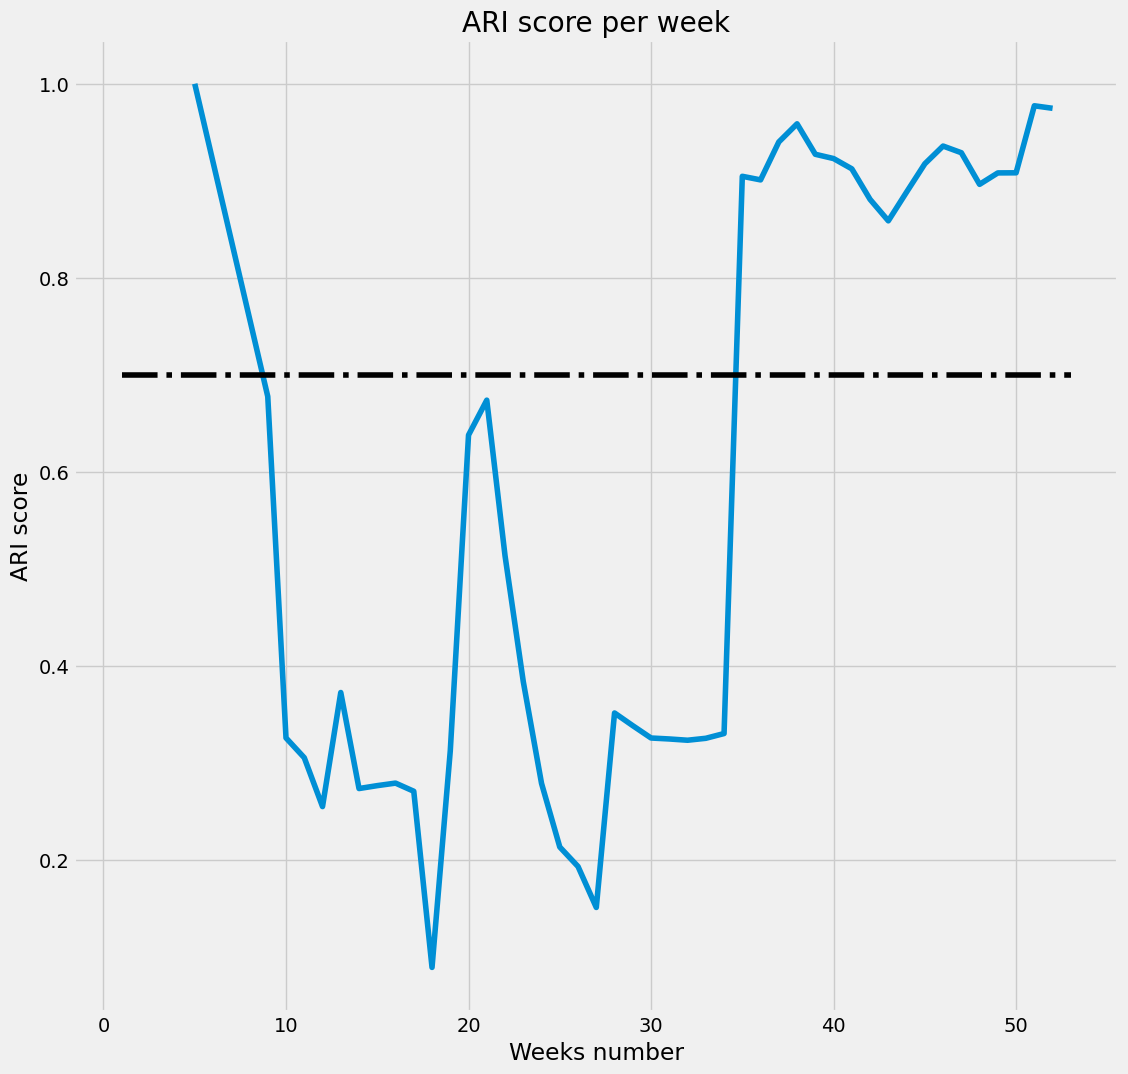

Starting simulation using the second method.

Considering periods of 1 week.
Not enough clients in one of the time periods, skipping this iteration.

Considering periods of 2 weeks.
Not enough clients in one of the time periods, skipping this iteration.

Considering periods of 3 weeks.
Not enough clients in one of the time periods, skipping this iteration.

Considering periods of 4 weeks.
Not enough clients in one of the time periods, skipping this iteration.

Considering periods of 5 weeks.
Number of clients in the first time period: 250, number of clients in the second time period: 95098.
ARI score:0.1169 for weeks number:5.

Considering periods of 6 weeks.
Number of clients in the first time period: 299, number of clients in the second time period: 95049.
ARI score:0.1169 for weeks number:6.

Considering periods of 7 weeks.
Number of clients in the first time period: 299, number of clients in the second time period: 95049.
ARI score:0.1169 for weeks number:7.

Considering periods of

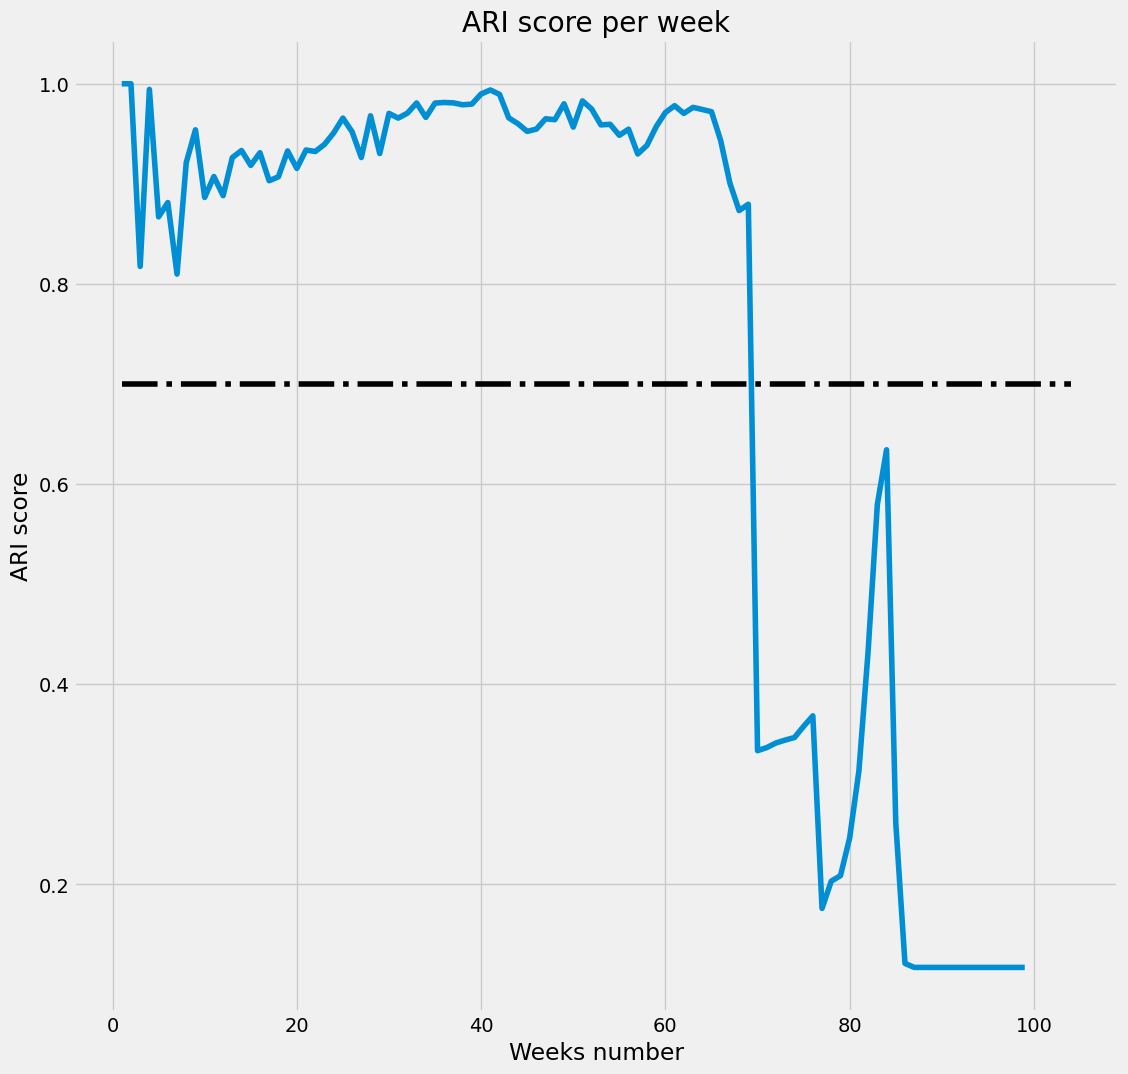

All processing is now done.


In [12]:
print("Starting simulation script.\n")
clients, overall_earliest_purchase_date, overall_latest_purchase_date = load_data()
print("Data loaded.\n")

overall_week_numbers = (
    overall_latest_purchase_date - overall_earliest_purchase_date).days // 7
print(f"Earliest purchase date:{overall_earliest_purchase_date}, "
      f"latest purchase date:{overall_latest_purchase_date}, overall week numbers:{overall_week_numbers}.\n")

create_ari_scores_plot_using_first_method(
    clients, overall_earliest_purchase_date, overall_week_numbers)

create_ari_scores_plot_using_second_method(
    clients,
    overall_earliest_purchase_date,
    overall_latest_purchase_date,
    overall_week_numbers)
print("All processing is now done.")